# CE880 Case Study
## Predicting if Delivery Will Reach on Time or Not

### Using classification to predict if the given item will be delivered on time depending on given features like warehouse, price, weight, ordered by, etc

To begin with, we import all modules needed in our code.
The modules include dataframe and array computation, plotting and machine learning model computation libraries.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, log_loss
from sklearn.naive_bayes import CategoricalNB

We then import our dataset and get some brief ideas about it.

In [2]:
df = pd.read_excel('Data_shipping.xlsx', index_col='ID')
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,ROT_Y
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [3]:
df

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,ROT_Y
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,1
2,F,Flight,4,5,216,2,low,M,59,3088,1
3,A,Flight,2,2,183,4,low,M,48,3374,1
4,B,Flight,3,3,176,4,medium,M,10,1177,1
5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...
10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10997,C,Ship,5,4,242,5,low,F,4,1155,0


Some columns are in the form of continuous variables, which could better be represented in ranges, or hence categorical variables.
Every unit of price will not be a required marker to predict if the product will be delivered on time, while an expensive product could be affiliated with on time delivery, therefore marking price ranges with on time delivery predictions. The same can be said about weight and discount.

We also proceed to encode all categorical columns to preserve the database in numerical format.

In [4]:
df
bins = [i * 100 + 1000 for i in range(35)]
categories = [i + 1 for i in range(35)]
cat = pd.cut(df.Weight_in_gms, bins, categories)
df.insert(len(df.columns) - 1, 'Weight_cat', cat)

bins = [i * 10 for i in range(31)]
categories = [i + 1 for i in range(31)]
cat = pd.cut(df.Cost_of_the_Product, bins, categories)
df.insert(5, 'Price_cat', cat)

bins = [i * 10 for i in range(100)]
categories = [i + 1 for i in range(10)]
cat = pd.cut(df.Discount_offered, bins, categories)
df.insert(5, 'Discount_cat', cat)

categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Price_cat', 'Weight_cat',
                    'Discount_cat']
enc = LabelEncoder()
for col in categorical_cols:
    enc.fit(df[col].values)
    df[col] = enc.transform(list(df[col].values))
df

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Discount_cat,Price_cat,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Weight_cat,ROT_Y
ID,,,,,,,,,,,,,,
1,3,0,4,2,177,4,8,3,1,0,44,1233,2,1
2,4,0,4,5,216,5,12,2,1,1,59,3088,20,1
3,0,0,2,2,183,4,9,4,1,1,48,3374,23,1
4,1,0,3,3,176,0,8,4,2,1,10,1177,1,1
5,2,0,2,2,184,4,9,3,2,0,46,2484,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,0,2,4,1,252,0,16,5,2,0,1,1538,5,1
10996,1,2,4,1,232,0,14,5,2,0,6,1247,2,0
10997,2,2,5,4,242,0,15,5,1,0,4,1155,1,0


We now have a dataset of categorical variables, ideal for most classification models.
We now check for missing values, when we find none, we move to check if any columns are highly correlated. In the case of correlation, we can drop out some columns.

<AxesSubplot:>

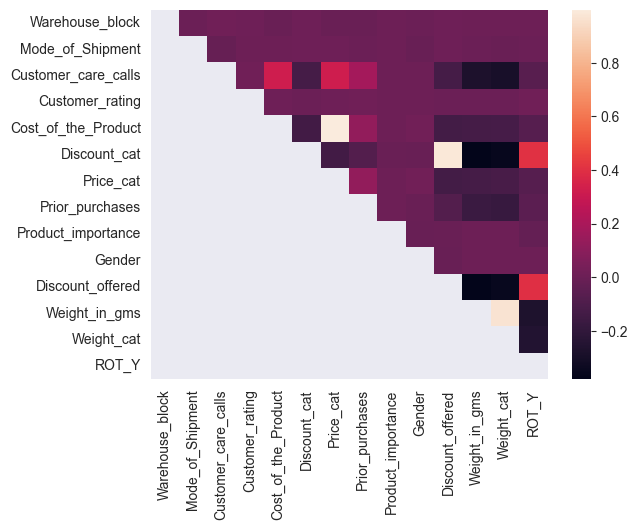

In [5]:
corr = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(bool))
sns.heatmap(corr)

In [6]:
df.isnull().sum()

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Discount_cat           0
Price_cat              0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Weight_cat             0
ROT_Y                  0
dtype: int64

In [7]:
# Dropping columns that we dont need.
df = df.drop(['Weight_in_gms', 'Cost_of_the_Product', 'Discount_cat'], axis=1)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Price_cat,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_cat,ROT_Y
ID,,,,,,,,,,,
1,3,0,4,2,8,3,1,0,44,2,1
2,4,0,4,5,12,2,1,1,59,20,1
3,0,0,2,2,9,4,1,1,48,23,1
4,1,0,3,3,8,4,2,1,10,1,1
5,2,0,2,2,9,3,2,0,46,14,1


We now move into training our models. To begin this, we define the features and the dependant variable as X and y.
We perform a simple train test split of 2:1 ratio to train our first model. We also apply stratification to ensure the same ratio of y values is preserved in the train and test sets.

In [8]:
y = df.ROT_Y
X = df.drop('ROT_Y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
X_train.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Price_cat,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_cat
ID,,,,,,,,,,
2684,4,2,3,1,6,3,1,1,57,8
8949,0,2,4,2,7,4,1,0,9,34
837,0,0,3,4,13,2,1,1,51,16
77,2,2,2,3,6,2,2,0,36,7
10819,3,0,4,1,4,4,1,0,5,34


We then train our first model, a K-nearest neighbours classifier. We test this from k=1 to k=15 to see what the best model would be.

In [9]:
accs = []
accs1 = []
for i in range(1, 15):
    model1 = KNeighborsClassifier(i)
    model1.fit(X_train, y_train)
    pred1 = model1.predict(X_test)
    pred2 = model1.predict(X_train)
    accuracy = f1_score(y_test, pred1)
    accuracy2 = f1_score(y_train, pred2)
    accs.append(accuracy)
    accs1.append(accuracy2)
    # print(report, '\n', report2)

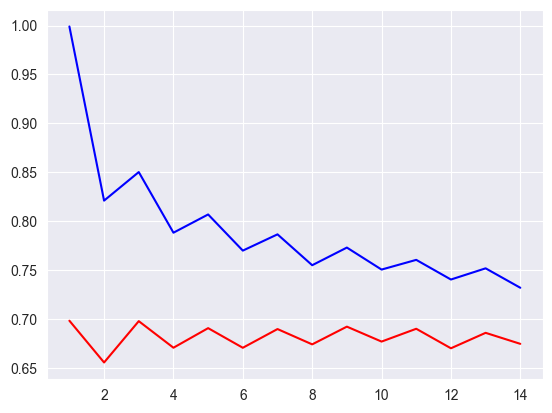

In [10]:
plt.plot()
p = sns.lineplot(x=range(1, 15), y=accs, color='r')
p = sns.lineplot(x=range(1, 15), y=accs1, color='b')

A K value of 3 seems ideal so we proceed to train our main model with K=3.
To begin training our models, we first implement a Stratified K-Fold cross validation.

In [11]:
folds = StratifiedKFold(5, shuffle=True)

In [12]:
knn_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    knn = KNeighborsClassifier(3)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_accuracy = f1_score(y_test, knn_pred)
    knn_mean.append(knn_accuracy)

np.mean(knn_mean)

0.7008202643956578

We now test some models to compare and test which is the best.
We use F1 Score to check our accuracy because of the ratios of the two classes being biased. We will also later compare models with their classification reports to check recall and precision.

In [13]:
svc_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    svc = SVC(kernel='rbf', gamma='auto', tol=1e-3, decision_function_shape='ovo')
    svc.fit(X_train, y_train)
    svc_pred = svc.predict(X_test)
    accuracy = f1_score(y_test, svc_pred)
    svc_mean.append(accuracy)

np.mean(svc_mean)

0.6948344011534594

In [14]:
sgd_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    sgd = SGDClassifier()
    sgd.fit(X_train, y_train)
    sgd_pred = sgd.predict(X_test)
    accuracy = f1_score(y_test, sgd_pred)
    sgd_mean.append(accuracy)

np.mean(sgd_mean)

0.6610001621829157

In [15]:
LR_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    lr = LogisticRegression(max_iter=1000)
    grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
    lr = GridSearchCV(lr, param_grid = grid_values,scoring = 'recall')
    lr.fit(X_train, y_train)
    LR_pred = lr.predict(X_test)
    accuracy = f1_score(y_test, LR_pred)
    LR_mean.append(accuracy)

np.mean(LR_mean)

0.6880156549851427

In [28]:
Dtree_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train, y_train)
    DTree_pred = dtree.predict(X_test)
    accuracy = f1_score(y_test, DTree_pred)
    Dtree_mean.append(accuracy)

np.mean(Dtree_mean)

0.702678770220406

In [17]:
RF_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    rf = RandomForestClassifier()
    param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth' : [5, 6, 7],
              'min_samples_split' : [2, 3, 5],
              'criterion' :['log_loss']
             }
    rf = GridSearchCV(rf, param_grid = param_grid,scoring = 'recall')
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    accuracy = f1_score(y_test, rf_pred)
    RF_mean.append(accuracy)

np.mean(RF_mean)

0.6618995461465034

In [18]:
NB_mean = []

for i, (train_index, test_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X[X.index.isin(train_index+1)], y[train_index+1]
    X_test, y_test = X[X.index.isin(test_index+1)], y[test_index+1]
    nb = CategoricalNB()
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    accuracy = f1_score(y_test, nb_pred)
    NB_mean.append(accuracy)

np.mean(NB_mean)

0.6485872975399564

Now we look at the classification reports of the top models.

In [19]:
# Random Forest
print('Random Forest')
print(classification_report(y_test, rf_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.56      0.93      0.70       887
           1       0.91      0.50      0.65      1312

    accuracy                           0.68      2199
   macro avg       0.74      0.72      0.67      2199
weighted avg       0.77      0.68      0.67      2199



In [29]:
# Decision Tree
print('Decision Tree')
print(classification_report(y_test, DTree_pred))

Decision Tree
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       887
           1       0.70      0.71      0.70      1312

    accuracy                           0.64      2199
   macro avg       0.63      0.63      0.63      2199
weighted avg       0.64      0.64      0.64      2199



In [21]:
# K-NN
print('KNN')
print(classification_report(y_test, knn_pred))

KNN
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       887
           1       0.72      0.69      0.71      1312

    accuracy                           0.66      2199
   macro avg       0.65      0.65      0.65      2199
weighted avg       0.66      0.66      0.66      2199



In [22]:
# SVC
print('SVC')
print(classification_report(y_test, svc_pred))

SVC
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       887
           1       0.75      0.62      0.68      1312

    accuracy                           0.65      2199
   macro avg       0.65      0.66      0.65      2199
weighted avg       0.67      0.65      0.66      2199



In [23]:
# Logistic Regression
print('Logistic Regression')
print(classification_report(y_test, LR_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       887
           1       0.69      0.67      0.68      1312

    accuracy                           0.62      2199
   macro avg       0.61      0.61      0.61      2199
weighted avg       0.62      0.62      0.62      2199



In [24]:
# SGD
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

           0       0.53      0.89      0.67       887
           1       0.87      0.47      0.61      1312

    accuracy                           0.64      2199
   macro avg       0.70      0.68      0.64      2199
weighted avg       0.73      0.64      0.64      2199



Comparing accuracies and classification reports, we can see even though some models performed similarly well, SVC and Random Forests had the highest accuracy-precision-recall combinations.

Also, as we are looking at inequal number of samples between the 2 classes, F1-score is a good estimator, and both SVC and Random forests have the highest F1-Scores in the models chosen.